In [ ]:
import keras
from keras.utils import np_utils
from keras.models import Sequential , Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers import Conv2D, Dense, MaxPooling2D, SeparableConv2D, BatchNormalization, ZeroPadding2D, GlobalAveragePooling2D,Flatten,Average, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop, Nadam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization , Activation , Input
from sklearn.utils import class_weight
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import Resnet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import cv2
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.utils import plot_model
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/labeled-images.zip"

with ZipFile(file_name,'r') as zip:
 zip.extractall()
 print('Done')

Done


In [ ]:
#important note: The size of the batch size plays an important role. 
#check whether the number of train, validation and test samples are
#absolutely divisible by the batch size. if not, make sure to add 1
# (+1) while fitting, evaluting and testing.
#reset the generators everytime before using them otherwise you will
#get wierd results

img_width, img_height = 224,224
train_data_dir = '/content/labeled-images/Training'
test_data_dir = '/content/labeled-images/Testing'
epochs = 10
batch_size = 11 #check if absolutely divisible for train, validation and test, else follow the procedure discussed above
num_classes= 15

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (img_width, img_height, 3)
model_input = Input(shape=input_shape)
print(model_input)

Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)


In [ ]:
#declare data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=4,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=False,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

#check the class indices
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

#true labels
Y_test=test_generator.classes
print(Y_test.shape)

#convert test labels to categorical
Y_test1=to_categorical(Y_test, num_classes=num_classes, dtype='float32')
print(Y_test1.shape)

Found 8788 images belonging to 15 classes.
Found 1859 images belonging to 15 classes.
Found 1859 images belonging to 15 classes.
{'barretts': 0, 'bbps-0-1': 1, 'bbps-2-3': 2, 'cecum': 3, 'dyed-lifted-polyps': 4, 'dyed-resection-margins': 5, 'esophagitis-a': 6, 'esophagitis-b-d': 7, 'impacted-stool': 8, 'polyps': 9, 'pylorus': 10, 'retroflex-rectum': 11, 'retroflex-stomach': 12, 'ulcerative-colitis-grade-0-1': 13, 'z-line': 14}
{'barretts': 0, 'bbps-0-1': 1, 'bbps-2-3': 2, 'cecum': 3, 'dyed-lifted-polyps': 4, 'dyed-resection-margins': 5, 'esophagitis-a': 6, 'esophagitis-b-d': 7, 'impacted-stool': 8, 'polyps': 9, 'pylorus': 10, 'retroflex-rectum': 11, 'retroflex-stomach': 12, 'ulcerative-colitis-grade-0-1': 13, 'z-line': 14}
{'barretts': 0, 'bbps-0-1': 1, 'bbps-2-3': 2, 'cecum': 3, 'dyed-lifted-polyps': 4, 'dyed-resection-margins': 5, 'esophagitis-a': 6, 'esophagitis-b-d': 7, 'impacted-stool': 8, 'polyps': 9, 'pylorus': 10, 'retroflex-rectum': 11, 'retroflex-stomach': 12, 'ulcerative-col

In [ ]:
#%% DenseNet121 model

def densenet_cnn(model_input):
    densenet_cnn = DenseNet121(weights='imagenet', include_top=False, input_tensor=model_input)
    x = densenet_cnn.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=densenet_cnn.input, outputs=predictions, name='densenet121_custom')
    return model

#instantiate the model
densenet_custom_model = densenet_cnn(model_input)


29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
#%% compile and train the DenseNet121 model
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
densenet_custom_model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint('kvasir.h5', monitor='val_accuracy', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='max', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board, reduce_lr]

#reset generators
train_generator.reset()
validation_generator.reset()

#train the model
history = densenet_custom_model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
  1/798 [..............................] - ETA: 0s - loss: 3.3104 - accuracy: 0.1818WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
798/798 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.7989
Epoch 00001: val_accuracy improved from -inf to 0.85691, saving model to kvasir.h5
798/798 [==============================] - 276s 346ms/step - loss: 0.6056 - accuracy: 0.7989 - val_loss: 0.3801 - val_accuracy: 0.8569
Epoch 2/10
798/798 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8861
Epoch 00002: val_accuracy improved from 0.85691 to 0.90533, saving model to kvasir.h5
798/798 [==============================] - 251s 315ms/step - loss:

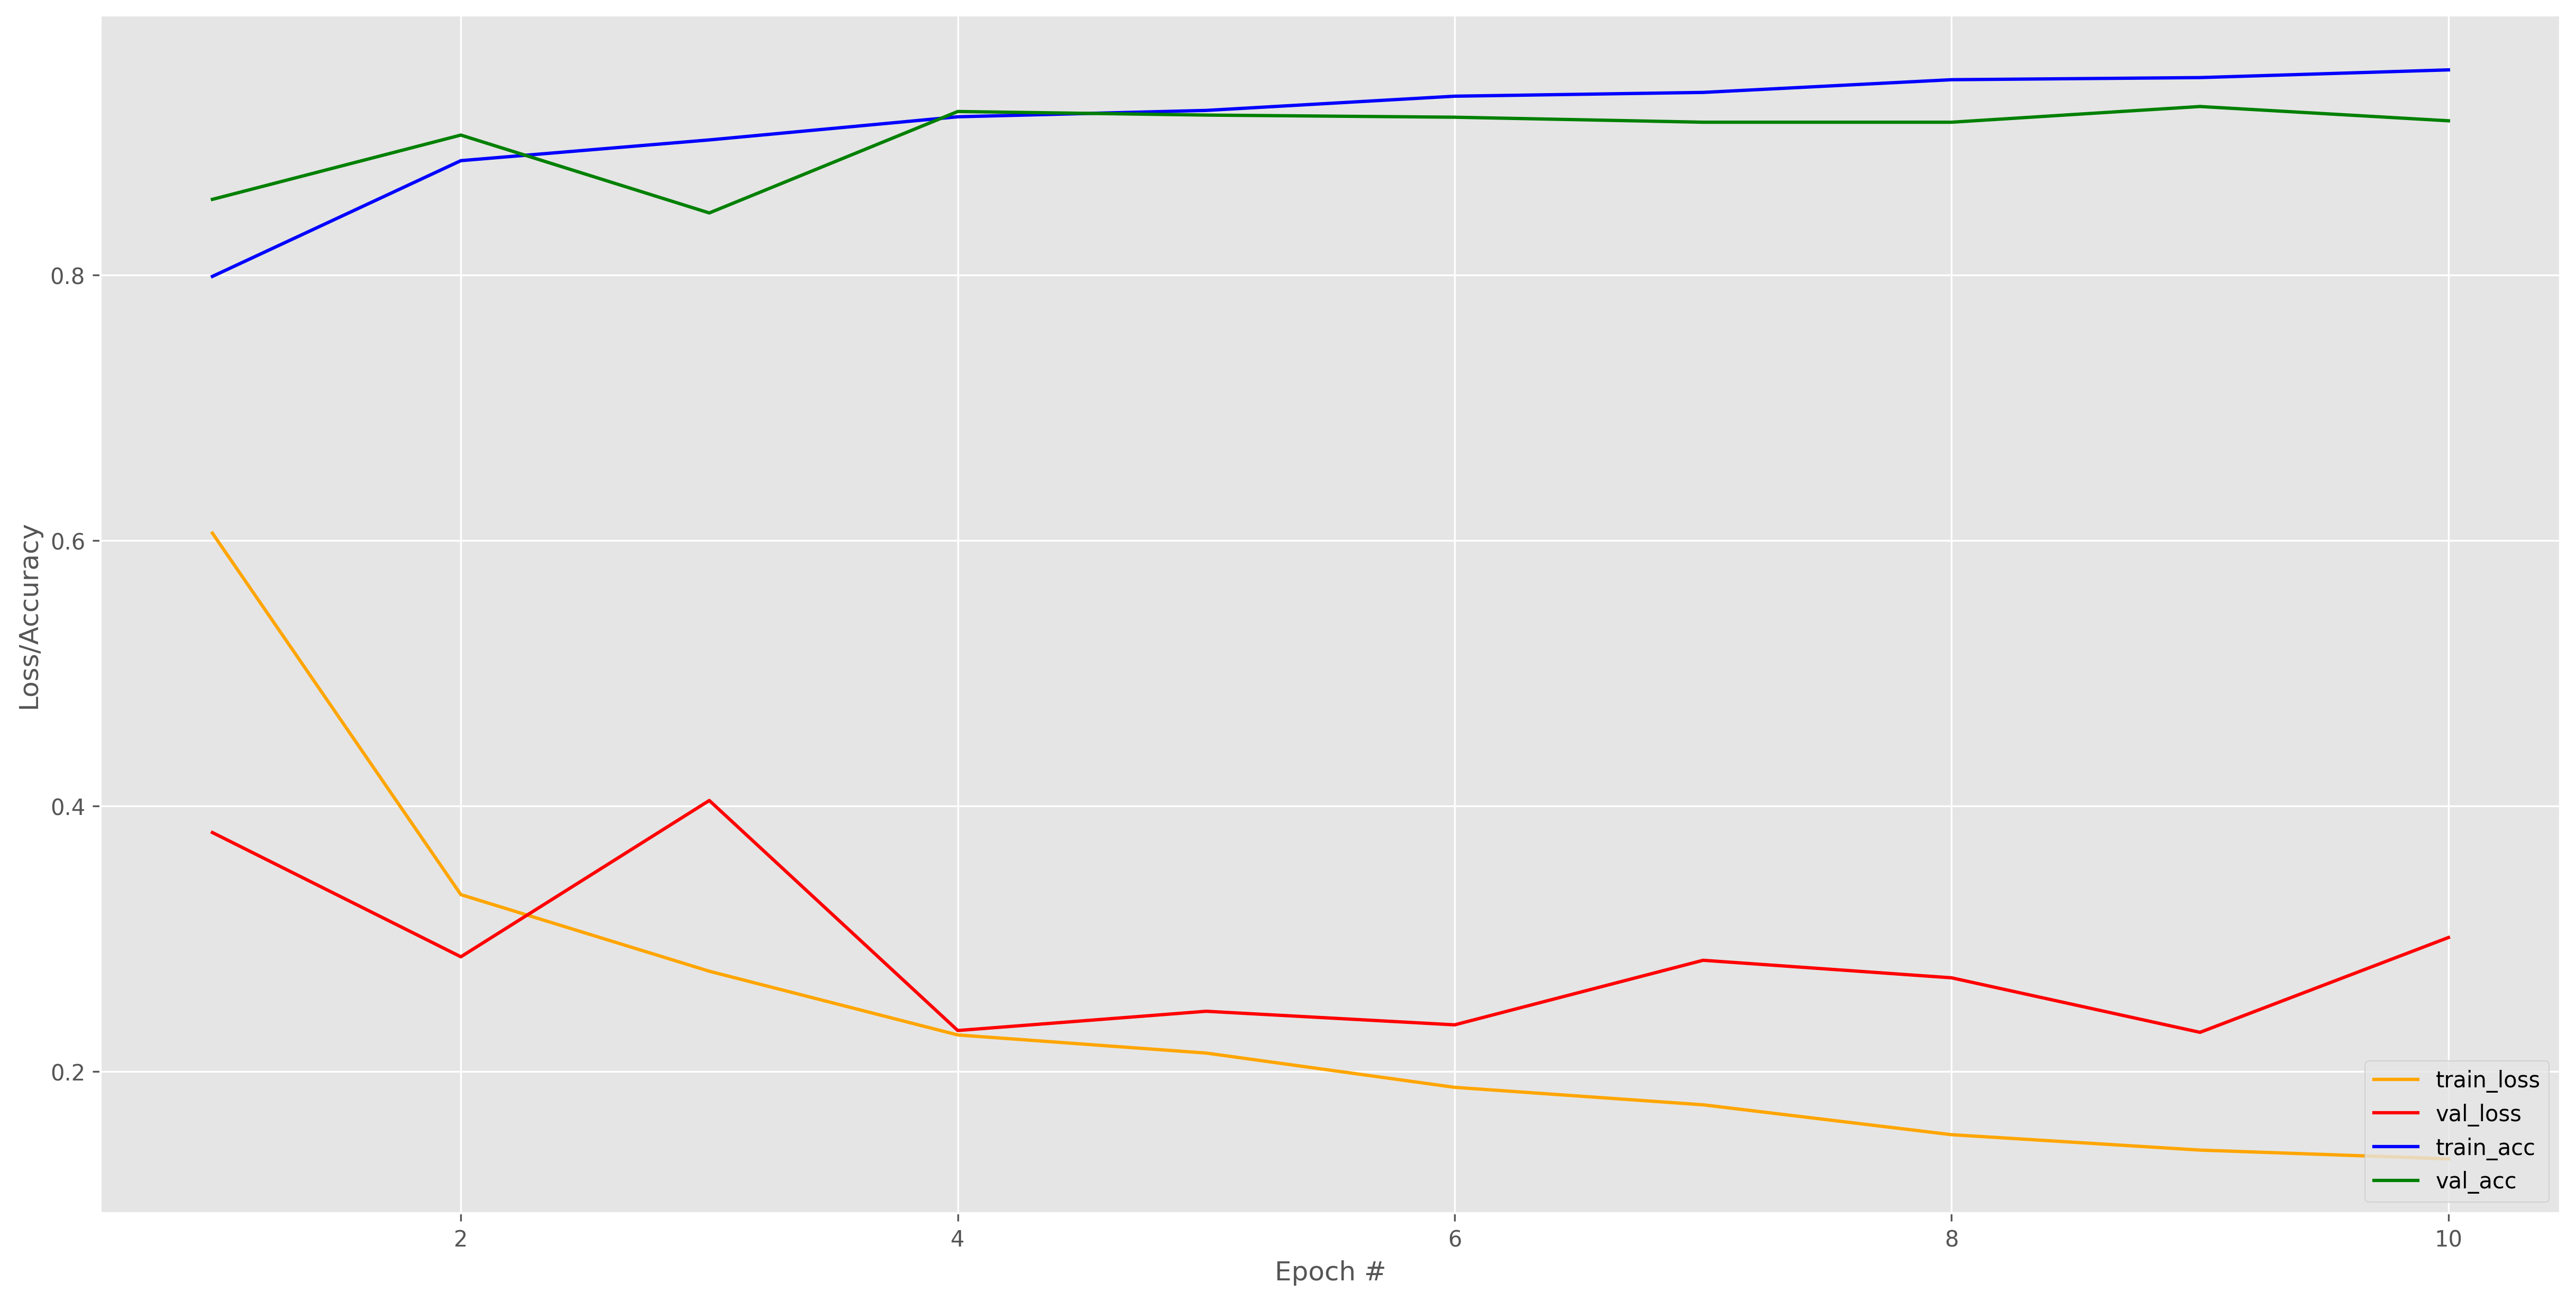

In [ ]:
# plot and save performance graphs

N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("DenseNet_custom_plot_modelA.png")

In [ ]:
#Evaluate the DenseNet model by loading the best weights
from tensorflow.keras.models import load_model


#reset validation generator
validation_generator.reset()

#calculate validation accuracy, make sure the batch size is absolutely divisible or add +1
scoredensenet = densenet_custom_model.evaluate_generator(validation_generator,
                                                         nb_validation_samples // batch_size, verbose=1)
print("Validation Accuracy = ",scoredensenet[1])

#measure performance on test data, first reset the test generator otherwise it gives wierd results
test_generator.reset()

#evaluate accuracy
densenet_custom_y_pred = densenet_custom_model.predict_generator(test_generator)
print(densenet_custom_y_pred.shape)
print(Y_test.shape)

Instructions for updating:
Please use Model.evaluate, which supports generators.
169/169 [==============================] - 26s 152ms/step - loss: 0.3010 - accuracy: 0.9161
Validation Accuracy =  0.9160839319229126
Instructions for updating:
Please use Model.predict, which supports generators.
(1859, 15)
(1859,)


In [ ]:
#Evaluate the performance metrics of the DenseNet model

accuracy = accuracy_score(Y_test1.argmax(axis=-1),densenet_custom_y_pred.argmax(axis=-1))
print('The test accuracy of the DenseNet model is: ', accuracy)

#Precision_score
densenet_ps = precision_score(Y_test1.argmax(axis=-1),densenet_custom_y_pred.argmax(axis=-1),average='macro')
print('The precision score of the DenseNet model is: ', densenet_ps)

#Recall score
densenet_rs = recall_score(Y_test1.argmax(axis=-1),densenet_custom_y_pred.argmax(axis=-1),average='macro')  
print('The recall score of the DenseNet model is: ', densenet_rs)

#evaluate matthews correlation coefficient
densenet_MCC = matthews_corrcoef(Y_test1.argmax(axis=-1),densenet_custom_y_pred.argmax(axis=-1))
print('The Matthews correlation coefficient value (MCC) for the Custom model is: ', densenet_MCC)

The test accuracy of the DenseNet model is:  0.916083916083916
The precision score of the DenseNet model is:  0.8870330300803295
The recall score of the DenseNet model is:  0.8610206437802169
The Matthews correlation coefficient value (MCC) for the Custom model is:  0.9093010689779784


In [ ]:
# custom definition for confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  9   0   0   0   0   0   7   2   0   0   0   0   0   0   6]
 [  0 117   1   1   1   0   0   0   0   0   0   0   0   0   0]
 [  0   1 225   0   0   0   0   0   4   0   0   0   0   0   0]
 [  0   0   0 196   1   0   0   0   0   1   0   0   0   2   0]
 [  0   0   0   0 159   6   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   6 119   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0  48   4   0   0   0   0   0   0  12]
 [  1   0   0   0   0   0  28  34   0   0   0   0   0   0   2]
 [  0   0   5   0   0   0   0   0  25   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 138   3   3   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0 178   0   0   1   1]
 [  0   0   0   0   0   0   0   0   0   0   0  84   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 120   0   0]
 [  0   0   0   1   0   0   1   0   0   8   0   2   0 118   0]
 [  2   0   0   0   0   0  38   2   0   0   0   0   0   0 133]]


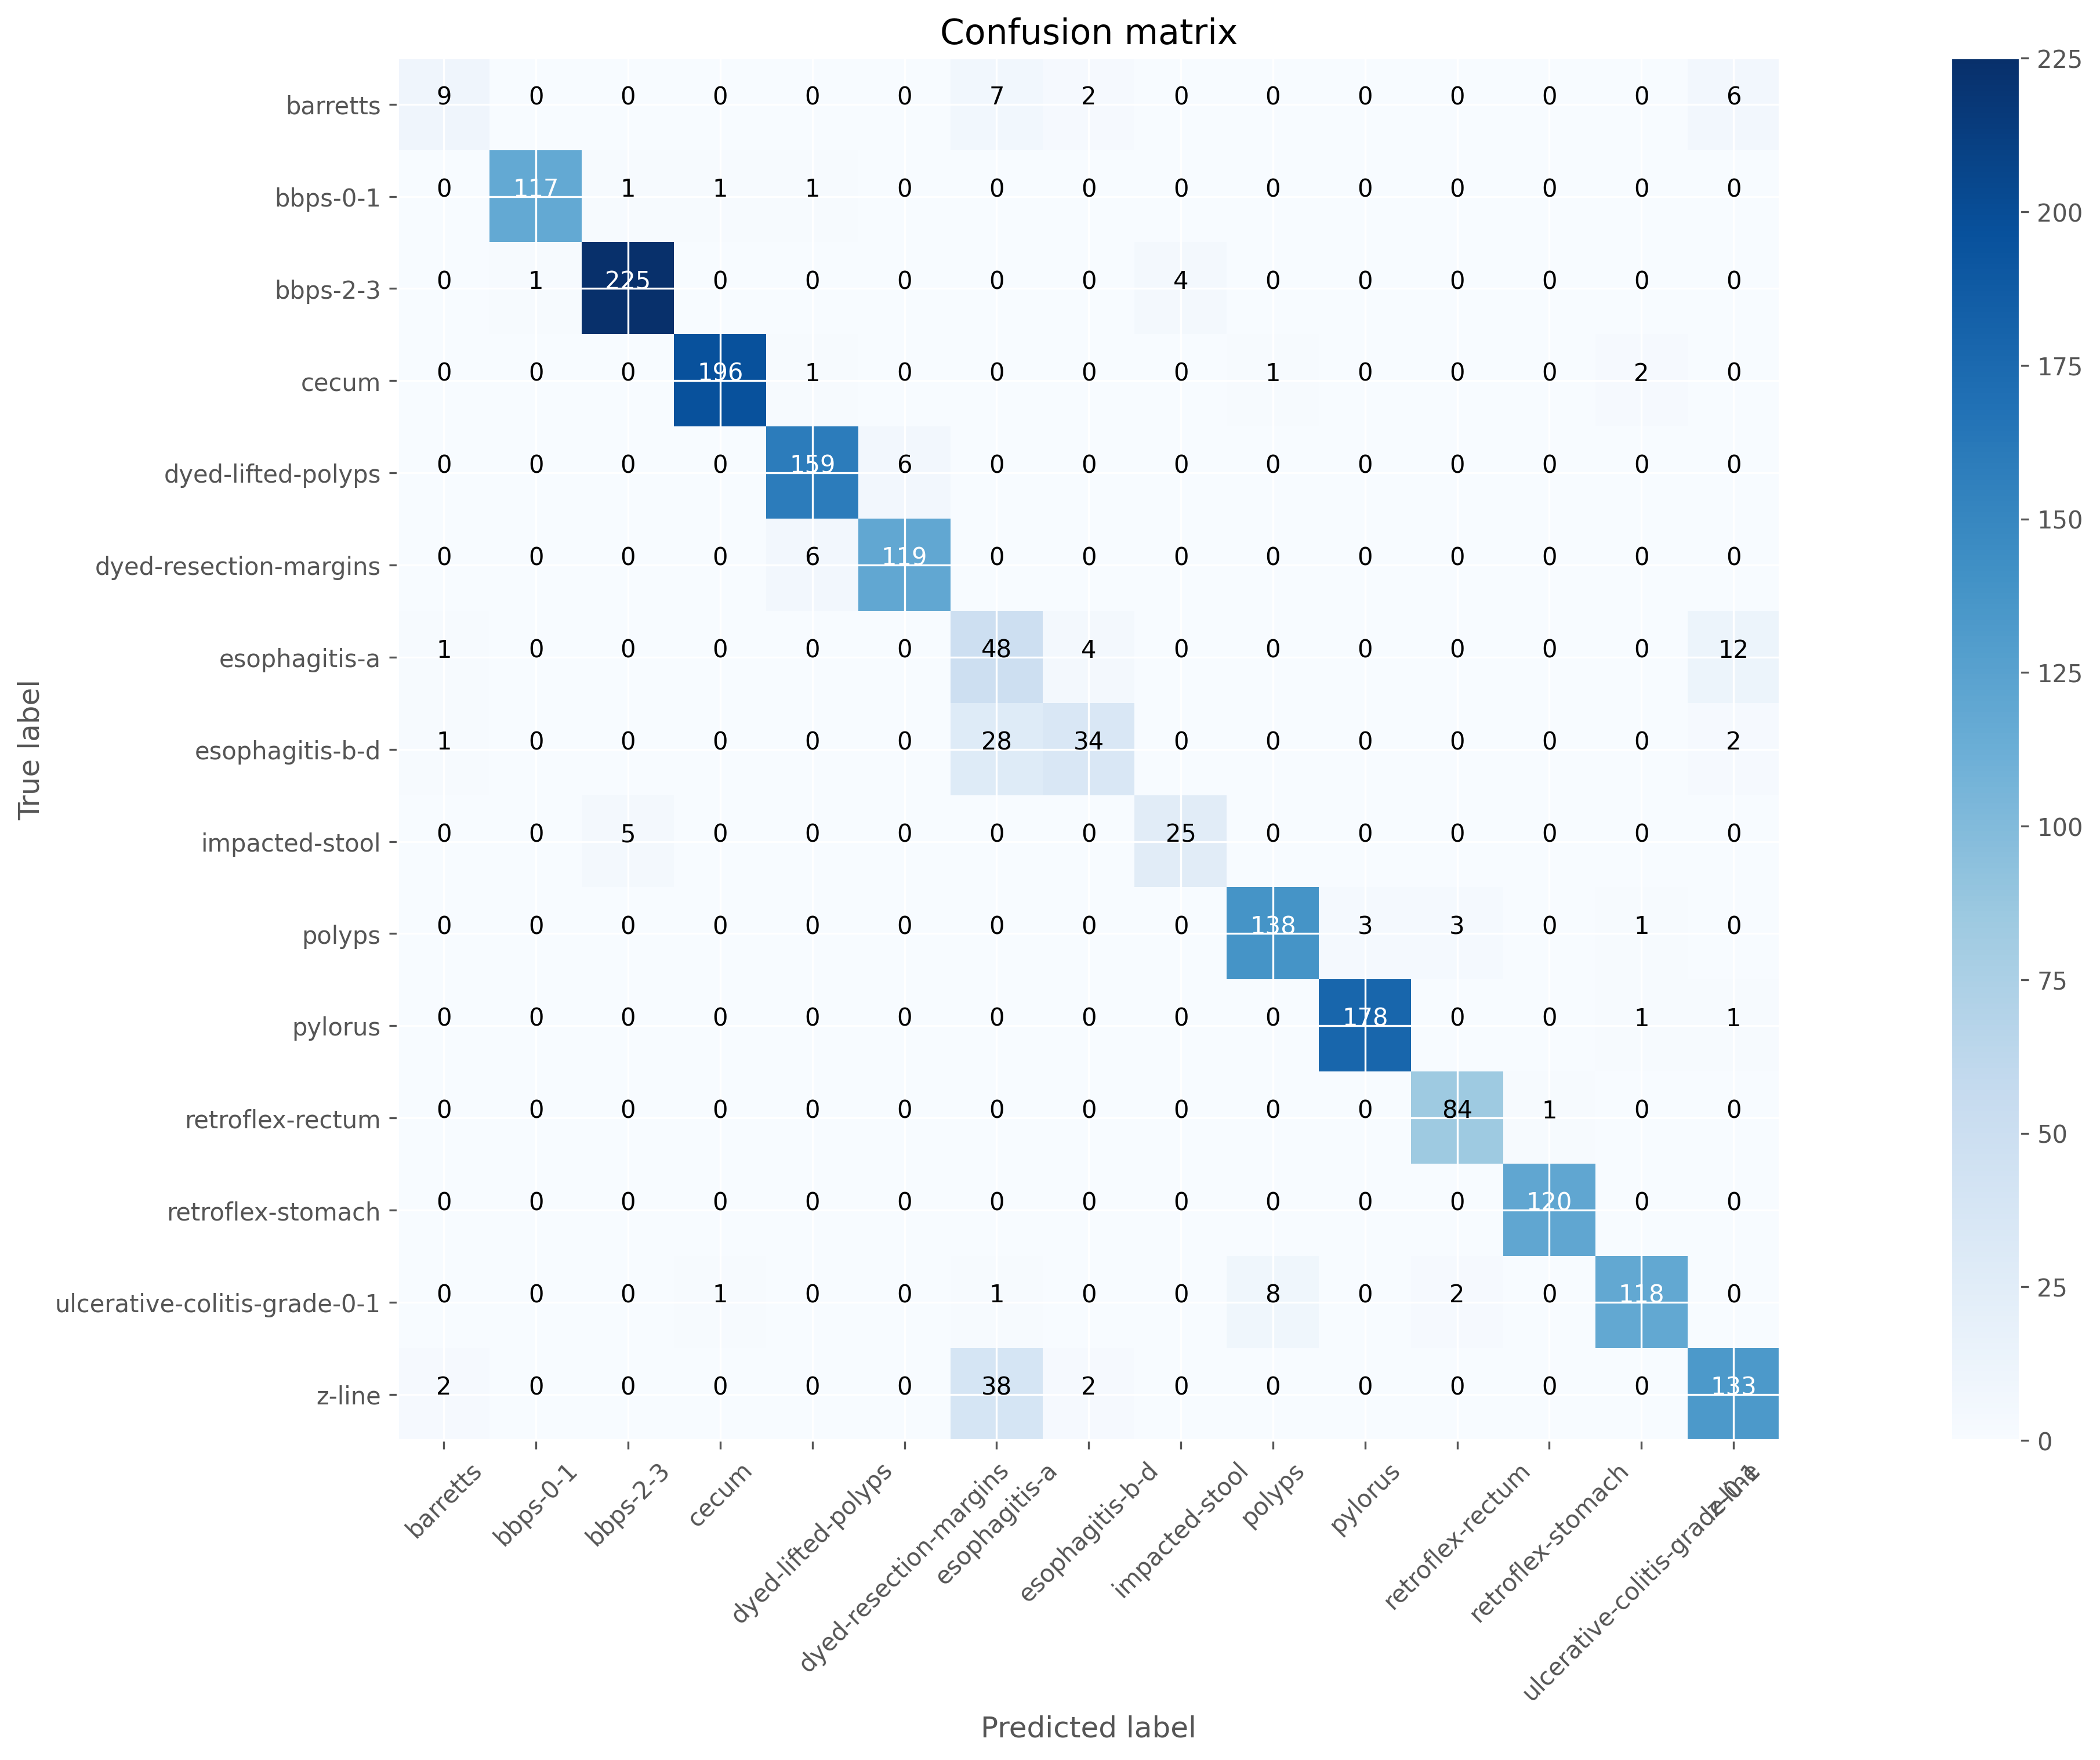

In [ ]:
#%% print classification report and plot confusion matrix

target_names = ['barretts', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'z-line'] 

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),densenet_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()



In [ ]:
#%% Inception-V3 model

def inceptionv3_cnn(model_input):
    inceptionv3_cnn = InceptionV3(weights='imagenet', include_top=False, input_tensor=model_input)
    x = inceptionv3_cnn.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inceptionv3_cnn.input, outputs=predictions, name='InceptionV3_custom')
    return model

#instantiate the model
inceptionv3_custom_model = inceptionv3_cnn(model_input)


87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
#%% compile and train the InceptionV3 model

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
inceptionv3_custom_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) 
checkpoint = ModelCheckpoint('inception.h5', monitor='val_accuracy', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='max', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5,
                              verbose=1, mode='max', min_lr=0.00001)
tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board, reduce_lr]

#reset generators
train_generator.reset()
validation_generator.reset()

#train the model
history = inceptionv3_custom_model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
798/798 [==============================] - ETA: 0s - loss: 0.7491 - accuracy: 0.7528
Epoch 00001: val_accuracy improved from -inf to 0.87897, saving model to inception.h5
798/798 [==============================] - 243s 305ms/step - loss: 0.7491 - accuracy: 0.7528 - val_loss: 0.3832 - val_accuracy: 0.8790
Epoch 2/10
798/798 [==============================] - ETA: 0s - loss: 0.3872 - accuracy: 0.8668
Epoch 00002: val_accuracy improved from 0.87897 to 0.88596, saving model to inception.h5
798/798 [==============================] - 241s 302ms/step - loss: 0.3872 - accuracy: 0.8668 - val_loss: 0.3624 - val_accuracy: 0.8860
Epoch 3/10
798/798 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8855
Epoch 00003: val_accuracy improved from 0.88596 to 0.90694, saving model to inception.h5
798/798 [==============================] - 240s 300ms/step - loss: 0.3311 - accuracy: 0.8855 - val_loss: 0.2772 - val_accuracy: 0.9069
Epoch 4/10
798/798 [=======================

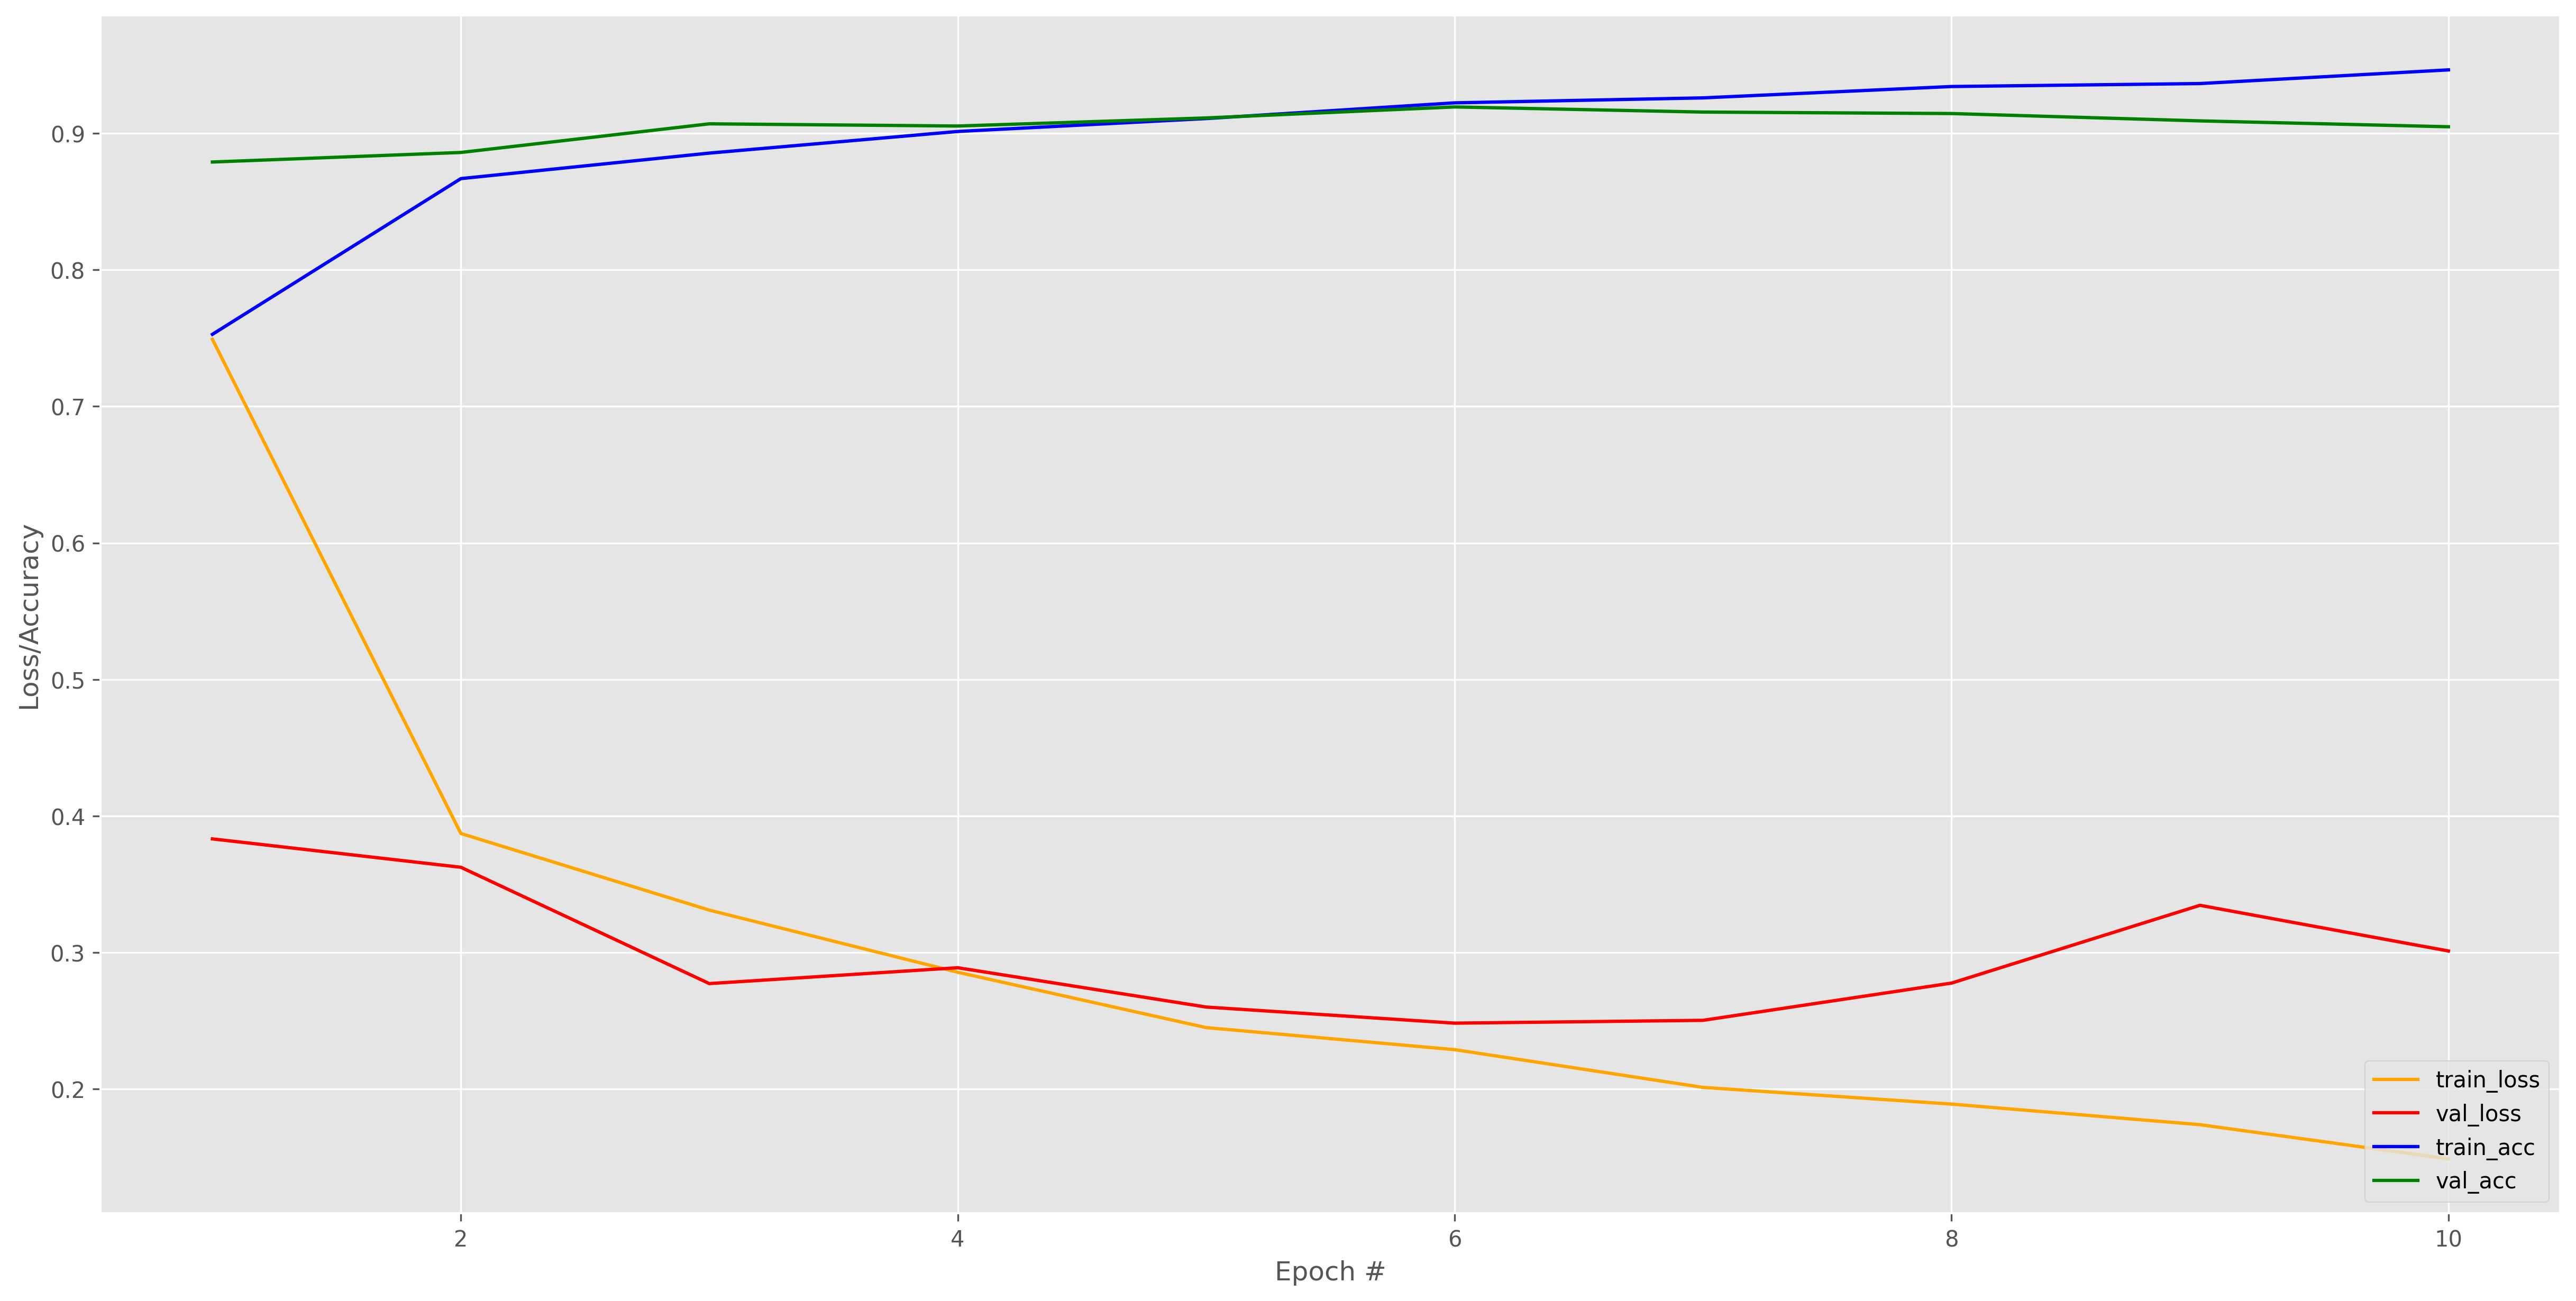

In [ ]:
# plot and save performance graphs

N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("InceptionV3_custom_plot_modelA.png")

In [ ]:
#Evaluate the Inception-V3 model by loading the best weights
from tensorflow.keras.models import load_model

#reset validation generator
validation_generator.reset()

#calculate validation accuracy, make sure the batch size is absolutely divisible or add +1
scoreinceptionv3 = inceptionv3_custom_model.evaluate_generator(validation_generator, 
                                                               nb_validation_samples // batch_size, verbose=1)
print("Validation Accuracy = ",scoreinceptionv3[1])

#measure performance on test data, first reset the test generator otherwise it gives wierd results
test_generator.reset()

#evaluate accuracy
inceptionv3_custom_y_pred = inceptionv3_custom_model.predict_generator(test_generator)
print(inceptionv3_custom_y_pred.shape)
print(Y_test.shape)

169/169 [==============================] - 26s 155ms/step - loss: 0.3011 - accuracy: 0.9048
Validation Accuracy =  0.904787540435791
(1859, 15)
(1859,)


In [ ]:
#Evaluate the performance metrics of the Inception model

accuracy = accuracy_score(Y_test1.argmax(axis=-1),inceptionv3_custom_y_pred.argmax(axis=-1))
print('The test accuracy of the inceptionv3 model is: ', accuracy)

#Precision_score
inceptionv3_ps = precision_score(Y_test1.argmax(axis=-1),inceptionv3_custom_y_pred.argmax(axis=-1),average='macro')
print('The precision score of the inceptionv3 model is: ', inceptionv3_ps)

#Recall score
inceptionv3_rs = recall_score(Y_test1.argmax(axis=-1),inceptionv3_custom_y_pred.argmax(axis=-1),average='macro')  
print('The recall score of the inceptionv3 model is: ', inceptionv3_rs)

#evaluate matthews correlation coefficient
inceptionv3_MCC = matthews_corrcoef(Y_test1.argmax(axis=-1),inceptionv3_custom_y_pred.argmax(axis=-1))
print('The Matthews correlation coefficient value (MCC) for the Custom model is: ', inceptionv3_MCC)

The test accuracy of the inceptionv3 model is:  0.9047875201721356
The precision score of the inceptionv3 model is:  0.8565844387258917
The recall score of the inceptionv3 model is:  0.8184621774595846
The Matthews correlation coefficient value (MCC) for the Custom model is:  0.8963283108093675


Confusion matrix, without normalization
[[  4   0   0   0   0   0   7   3   0   0   0   0   0   0  10]
 [  0 117   1   2   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1 227   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0 195   1   0   0   0   0   1   0   1   0   2   0]
 [  0   0   0   0 157   5   0   0   0   1   1   0   0   0   1]
 [  0   1   0   0  16 108   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  33  11   0   0   1   0   0   0  20]
 [  2   0   0   0   0   0  17  40   0   0   2   0   0   0   4]
 [  0   0  13   0   0   0   0   0  17   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0 131   4   3   0   6   0]
 [  0   0   0   0   0   0   0   0   0   0 180   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  83   2   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 120   0   0]
 [  0   0   0   2   0   0   0   2   0   1   0   1   0 124   0]
 [  2   0   0   0   1   0  18   3   0   0   5   0   0   0 146]]


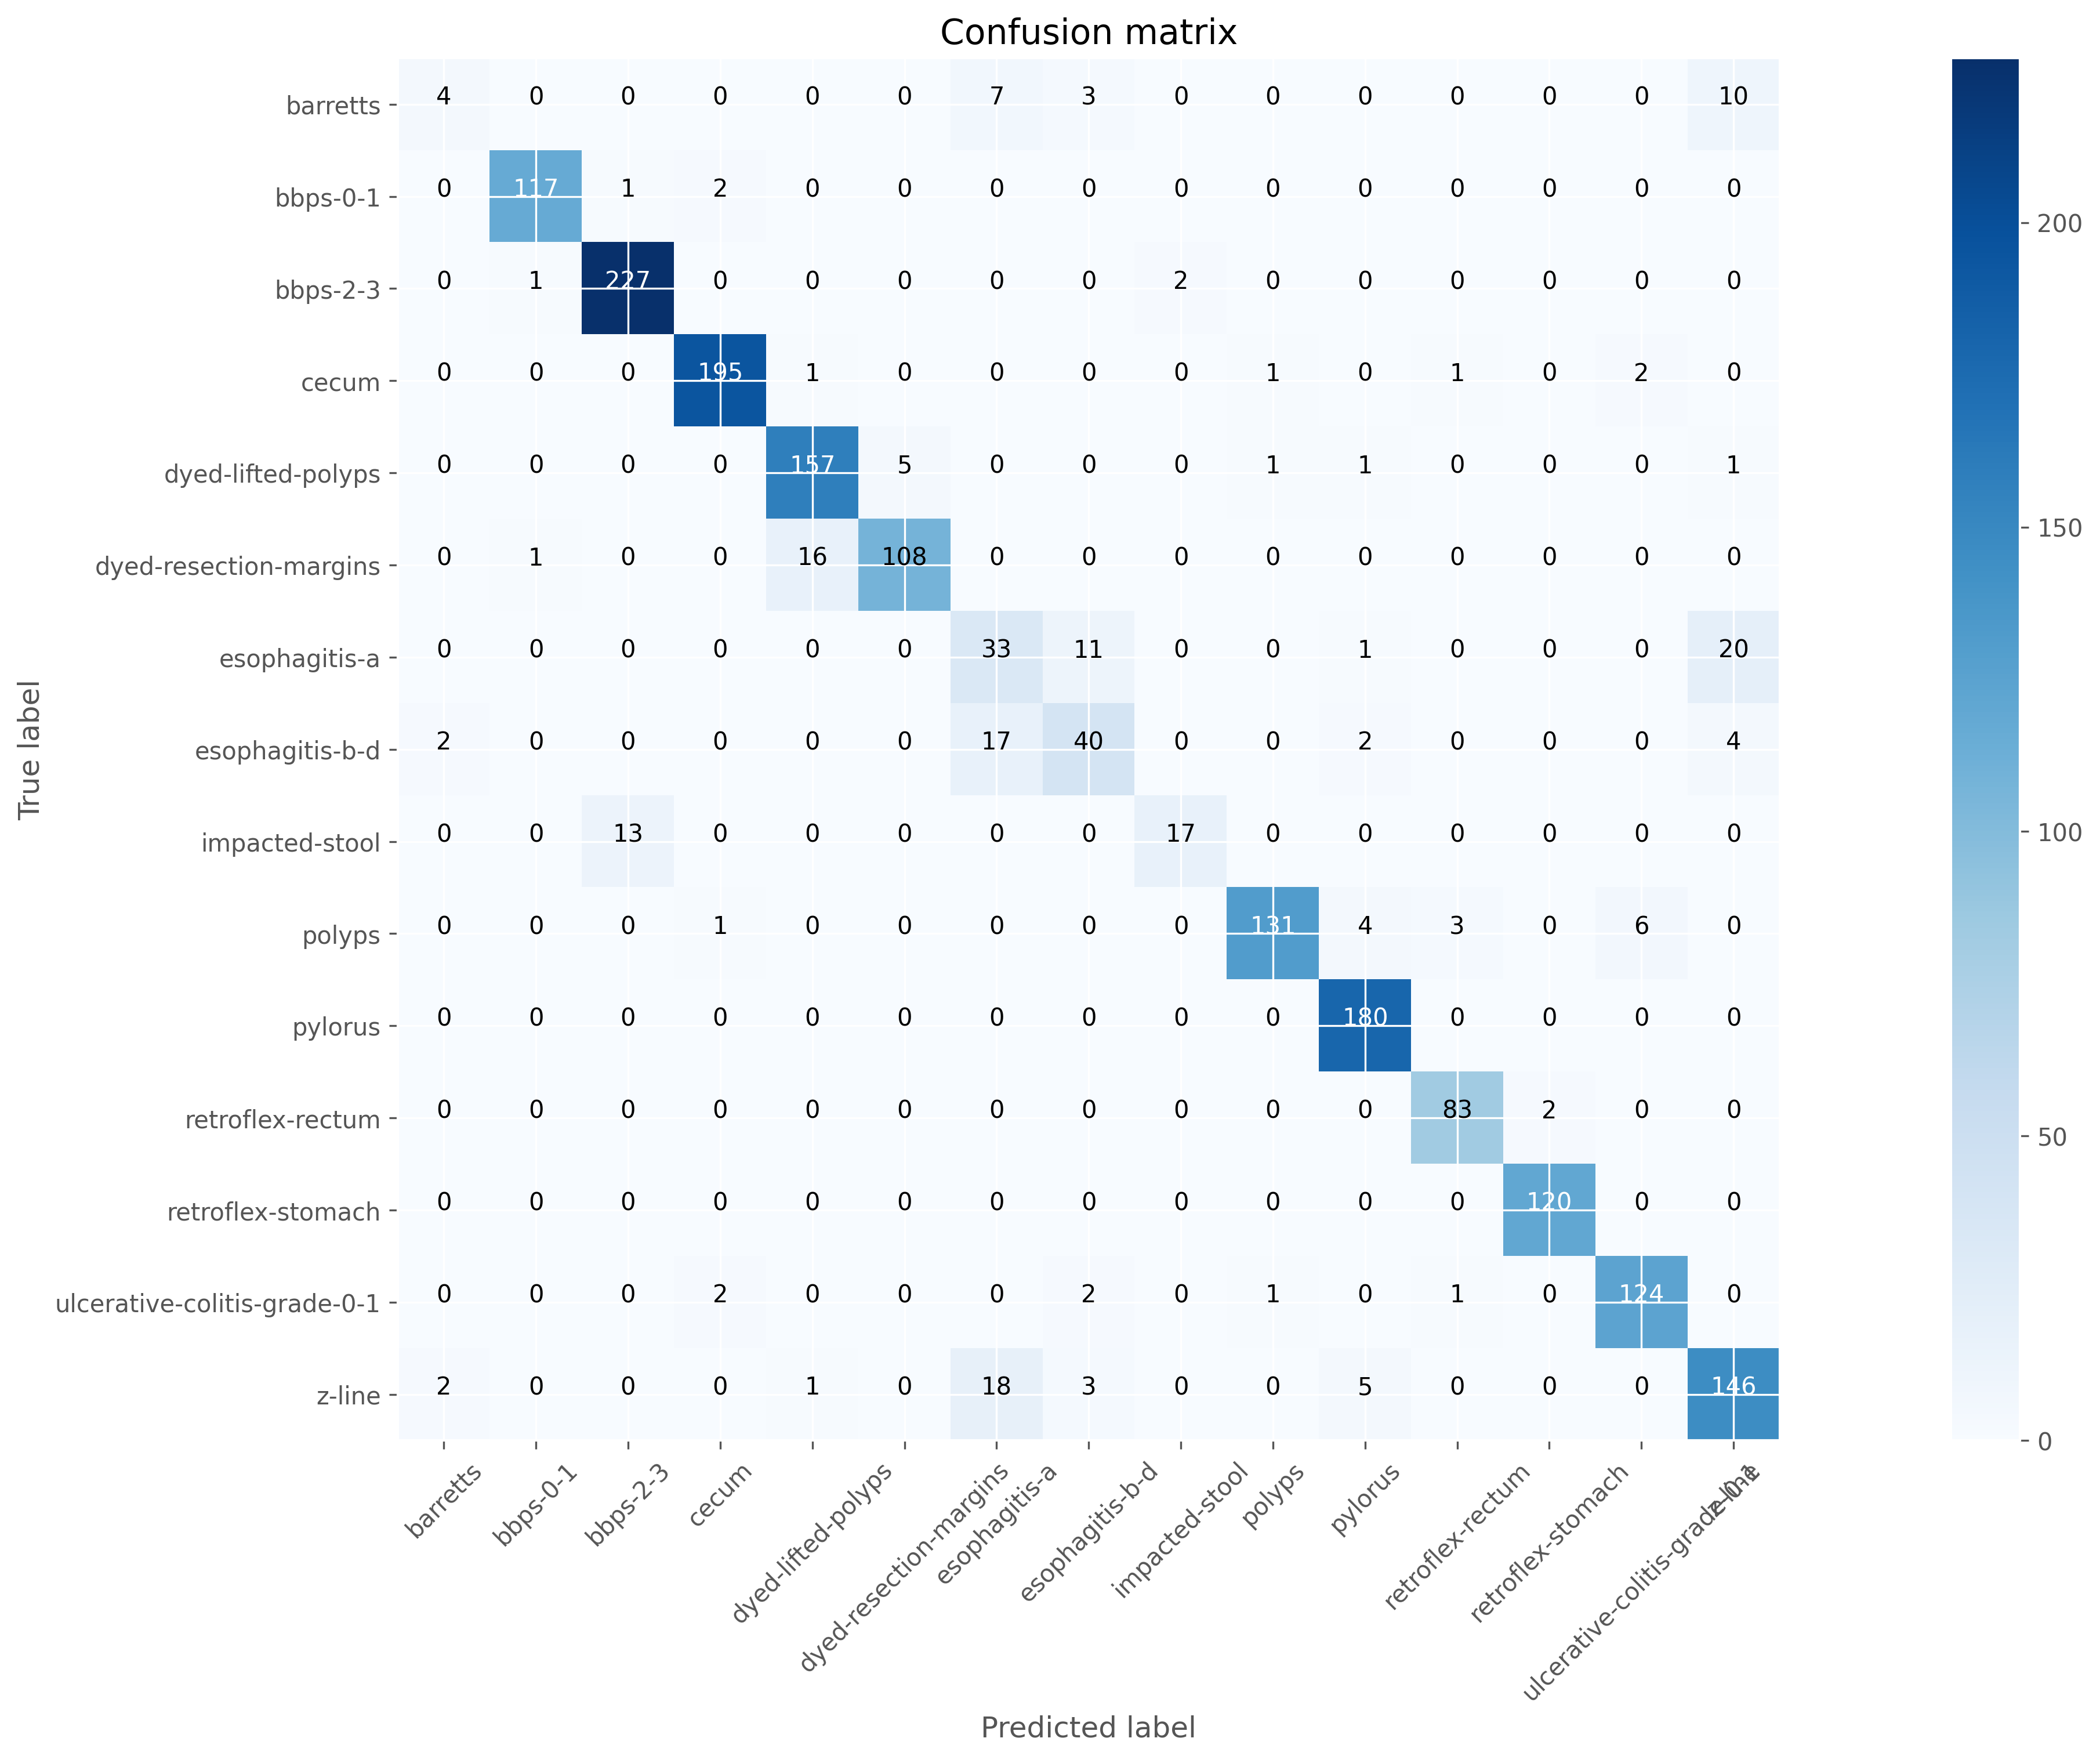

In [ ]:
#%% print classification report and plot confusion matrix

target_names = ['barretts', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'z-line'] 
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),inceptionv3_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


In [ ]:
#%% VGG16 model: The model layers are renamed to avoid common laqyer name issues
#while constructing the ensemble

def vgg16_cnn(model_input):
    vgg16_cnn = VGG16(weights='imagenet', include_top=False, input_tensor=model_input)
    vgg16_cnn = Model(inputs=vgg16_cnn.input, outputs=vgg16_cnn.get_layer('block5_conv3').output)
    x = vgg16_cnn.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg16_cnn.input, outputs=predictions, name='vgg16_custom') 
    return model

#instantiate the model
vgg16_custom_model = vgg16_cnn(model_input)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#%% compile and train the VGG16 model

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)  
vgg16_custom_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy']) 
checkpoint = ModelCheckpoint('vgg16.h5', monitor='val_accuracy', verbose=1, 
                             save_weights_only=False, save_best_only=True, mode='max', period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5,
                              verbose=1, mode='max', min_lr=0.00001)
tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board, reduce_lr]

#reset generators
train_generator.reset()
validation_generator.reset()

#train the model
history = vgg16_custom_model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size)

Epoch 1/10
798/798 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.6065
Epoch 00001: val_accuracy improved from -inf to 0.75094, saving model to vgg16.h5
798/798 [==============================] - 273s 342ms/step - loss: 1.0969 - accuracy: 0.6065 - val_loss: 0.6564 - val_accuracy: 0.7509
Epoch 2/10
798/798 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.7836
Epoch 00002: val_accuracy improved from 0.75094 to 0.77353, saving model to vgg16.h5
798/798 [==============================] - 269s 337ms/step - loss: 0.5779 - accuracy: 0.7836 - val_loss: 0.5972 - val_accuracy: 0.7735
Epoch 3/10
798/798 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8289
Epoch 00003: val_accuracy improved from 0.77353 to 0.85853, saving model to vgg16.h5
798/798 [==============================] - 267s 334ms/step - loss: 0.4683 - accuracy: 0.8289 - val_loss: 0.4635 - val_accuracy: 0.8585
Epoch 4/10
798/798 [==============================] - E

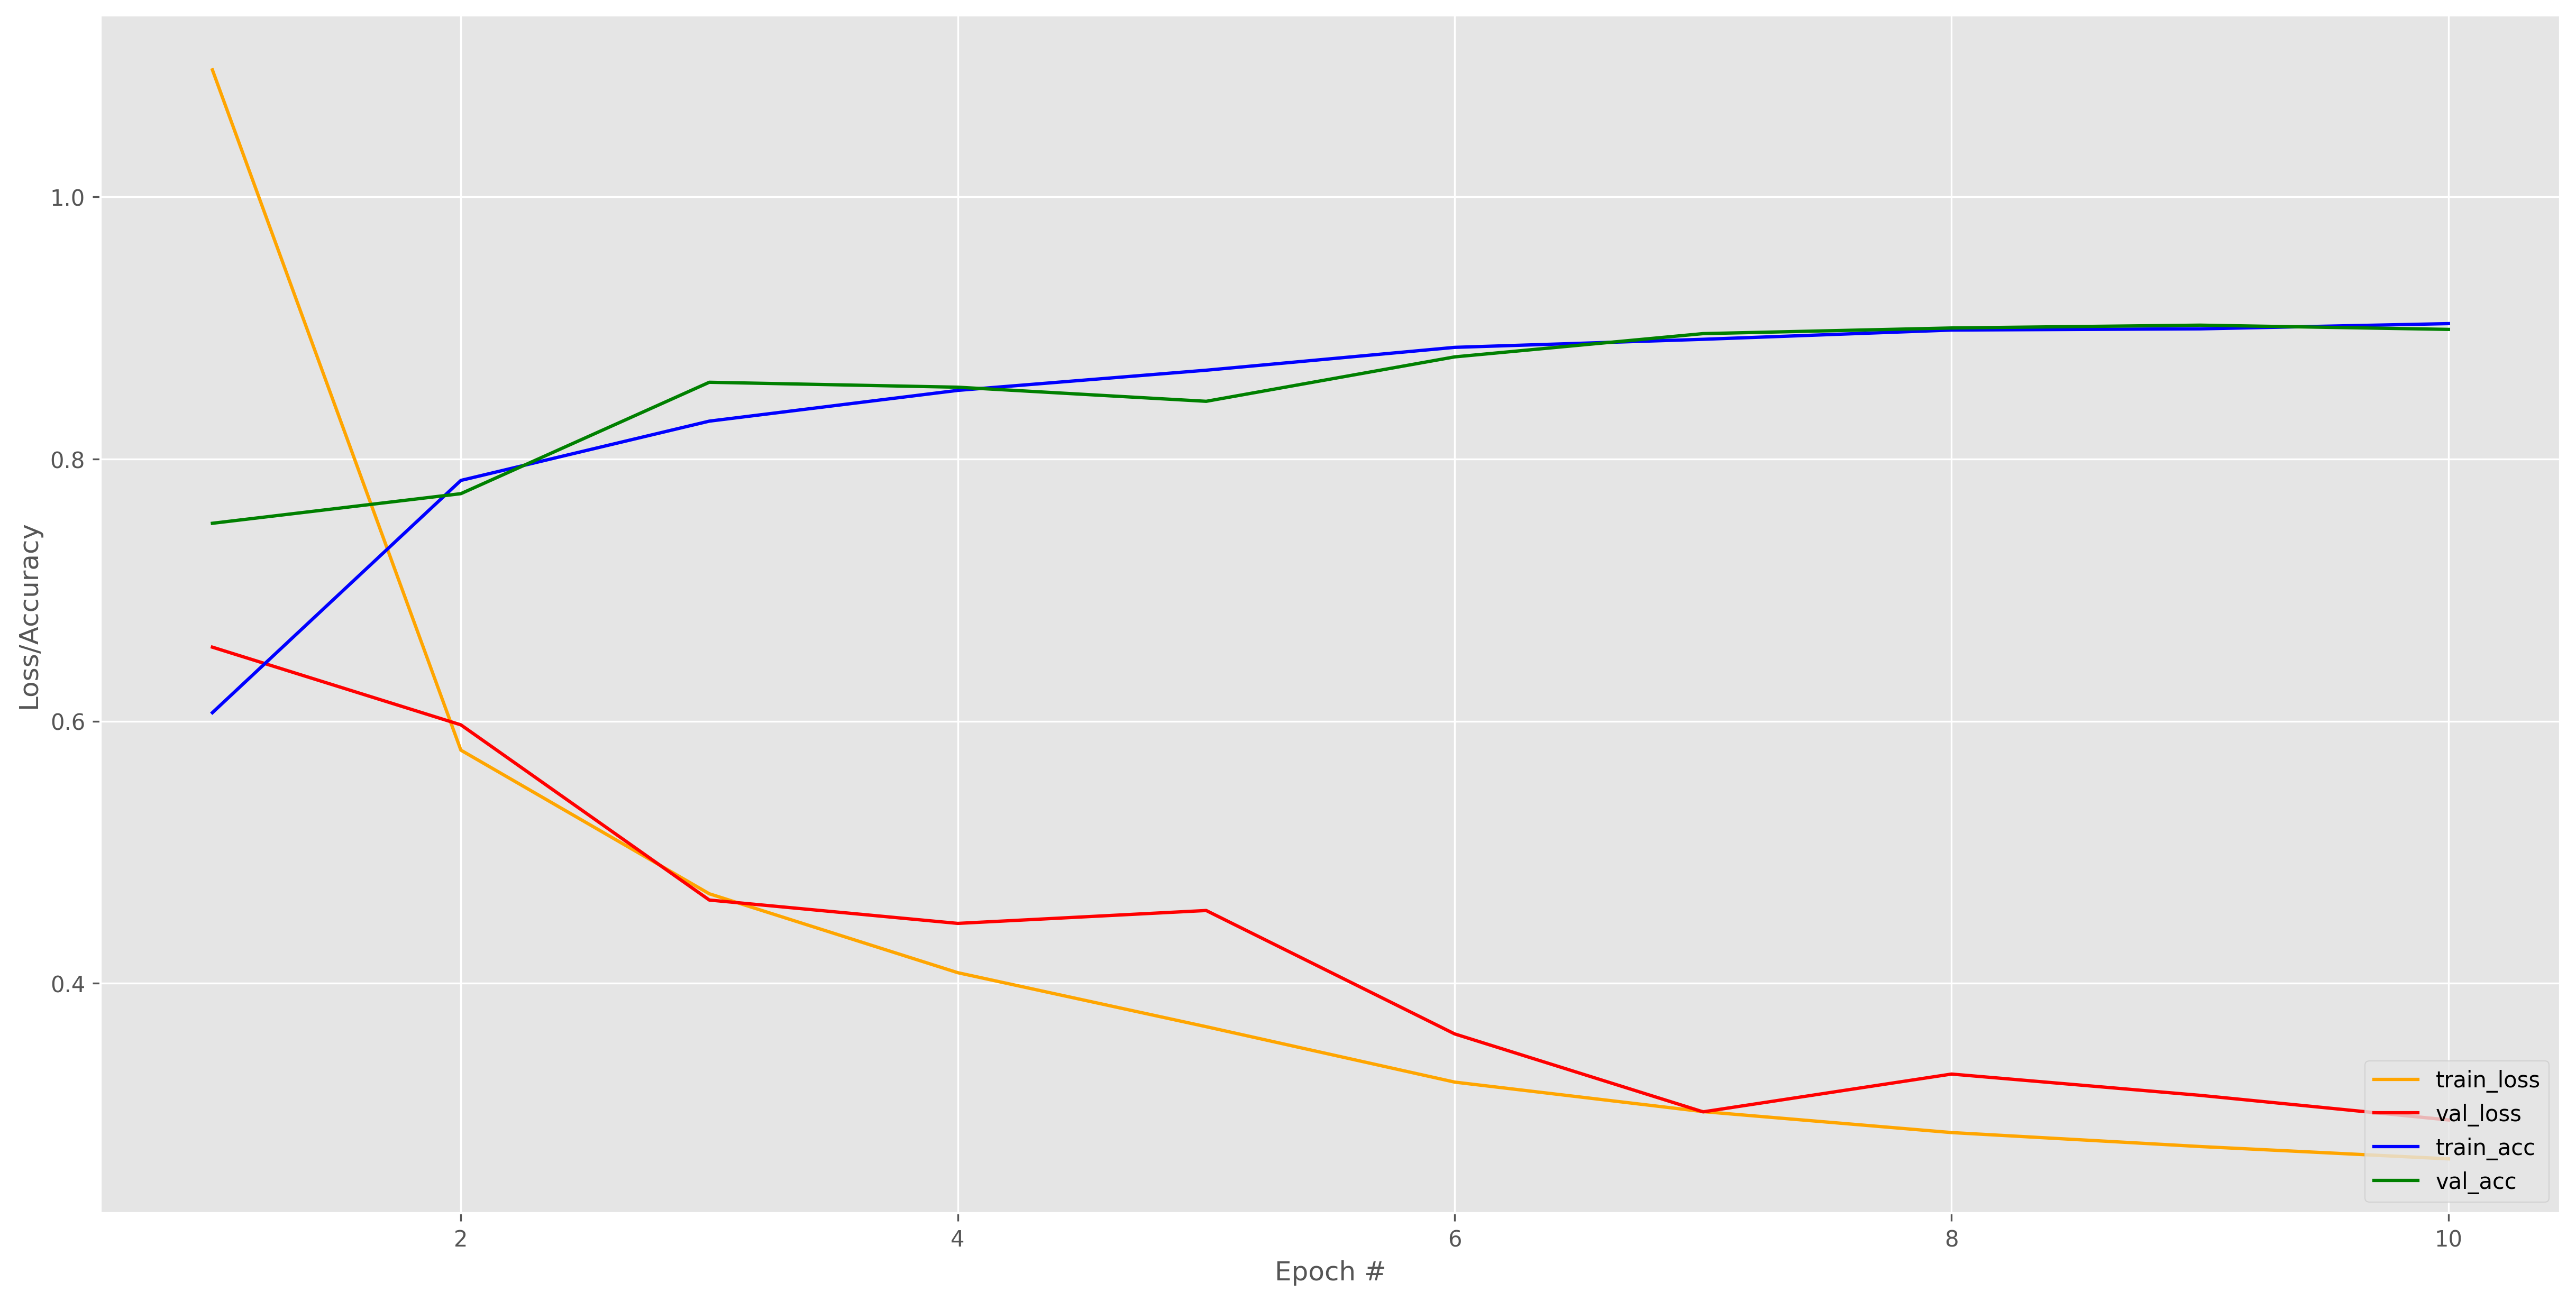

In [ ]:

N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("vgg16_custom_plot_modelA.png")

In [ ]:
#Evaluate the Ivgg16 model by loading the best weights
from tensorflow.keras.models import load_model

#reset validation generator
validation_generator.reset()

#calculate validation accuracy, make sure the batch size is absolutely divisible or add +1
scorevgg16 = vgg16_custom_model.evaluate_generator(validation_generator, 
                                                   nb_validation_samples // batch_size, verbose=1)
print("Validation Accuracy = ",scorevgg16[1])

#measure performance on test data, first reset the test generator otherwise it gives wierd results
test_generator.reset()

#evaluate accuracy 
vgg16_custom_y_pred = vgg16_custom_model.predict_generator(test_generator)

#print prediction shapes
print(vgg16_custom_y_pred.shape)
print(Y_test.shape)
print(Y_test1.shape)

169/169 [==============================] - 26s 156ms/step - loss: 0.2957 - accuracy: 0.8989
Validation Accuracy =  0.8988703489303589
(1859, 15)
(1859,)
(1859, 15)


In [ ]:
#Evaluate the performance metrics of the vgg16 model

accuracy = accuracy_score(Y_test1.argmax(axis=-1),vgg16_custom_y_pred.argmax(axis=-1))
print('The test accuracy of the vgg16 model is: ', accuracy)

#Precision_score
vgg16_ps = precision_score(Y_test1.argmax(axis=-1),vgg16_custom_y_pred.argmax(axis=-1),average='macro')
print('The precision score of the vgg16 model is: ', vgg16_ps)

#Recall score
vgg16_rs = recall_score(Y_test1.argmax(axis=-1),vgg16_custom_y_pred.argmax(axis=-1),average='macro')  
print('The recall score of the vgg16 model is: ', vgg16_rs)

#evaluate matthews correlation coefficient
vgg16_MCC = matthews_corrcoef(Y_test1.argmax(axis=-1),vgg16_custom_y_pred.argmax(axis=-1))
print('The Matthews correlation coefficient value (MCC) for the Custom model is: ', vgg16_MCC)

The test accuracy of the vgg16 model is:  0.898870360408822
The precision score of the vgg16 model is:  0.8192769641275224
The recall score of the vgg16 model is:  0.8229133029999597
The Matthews correlation coefficient value (MCC) for the Custom model is:  0.8902276590284908


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[  0   0   0   0   0   0  14   5   0   0   0   1   0   0   4]
 [  0 117   1   1   1   0   0   0   0   0   0   0   0   0   0]
 [  0   1 227   0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   0   0 197   0   0   0   0   0   1   0   0   0   2   0]
 [  0   0   0   1 153   9   0   0   0   2   0   0   0   0   0]
 [  0   0   0   0   7 118   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  32  12   0   0   0   0   1   0  20]
 [  0   0   0   0   0   1  11  44   0   0   1   0   0   0   8]
 [  0   0   5   0   0   0   0   0  25   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 142   0   3   0   0   0]
 [  0   1   0   0   0   0   0   0   0  16 163   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1 119   0   0]
 [  0   0   0   2   0   0   0   0   0  14   0   1   0 113   0]
 [  0   0   0   0   0   0  33   2   0   2   1   0   0   1 136]]


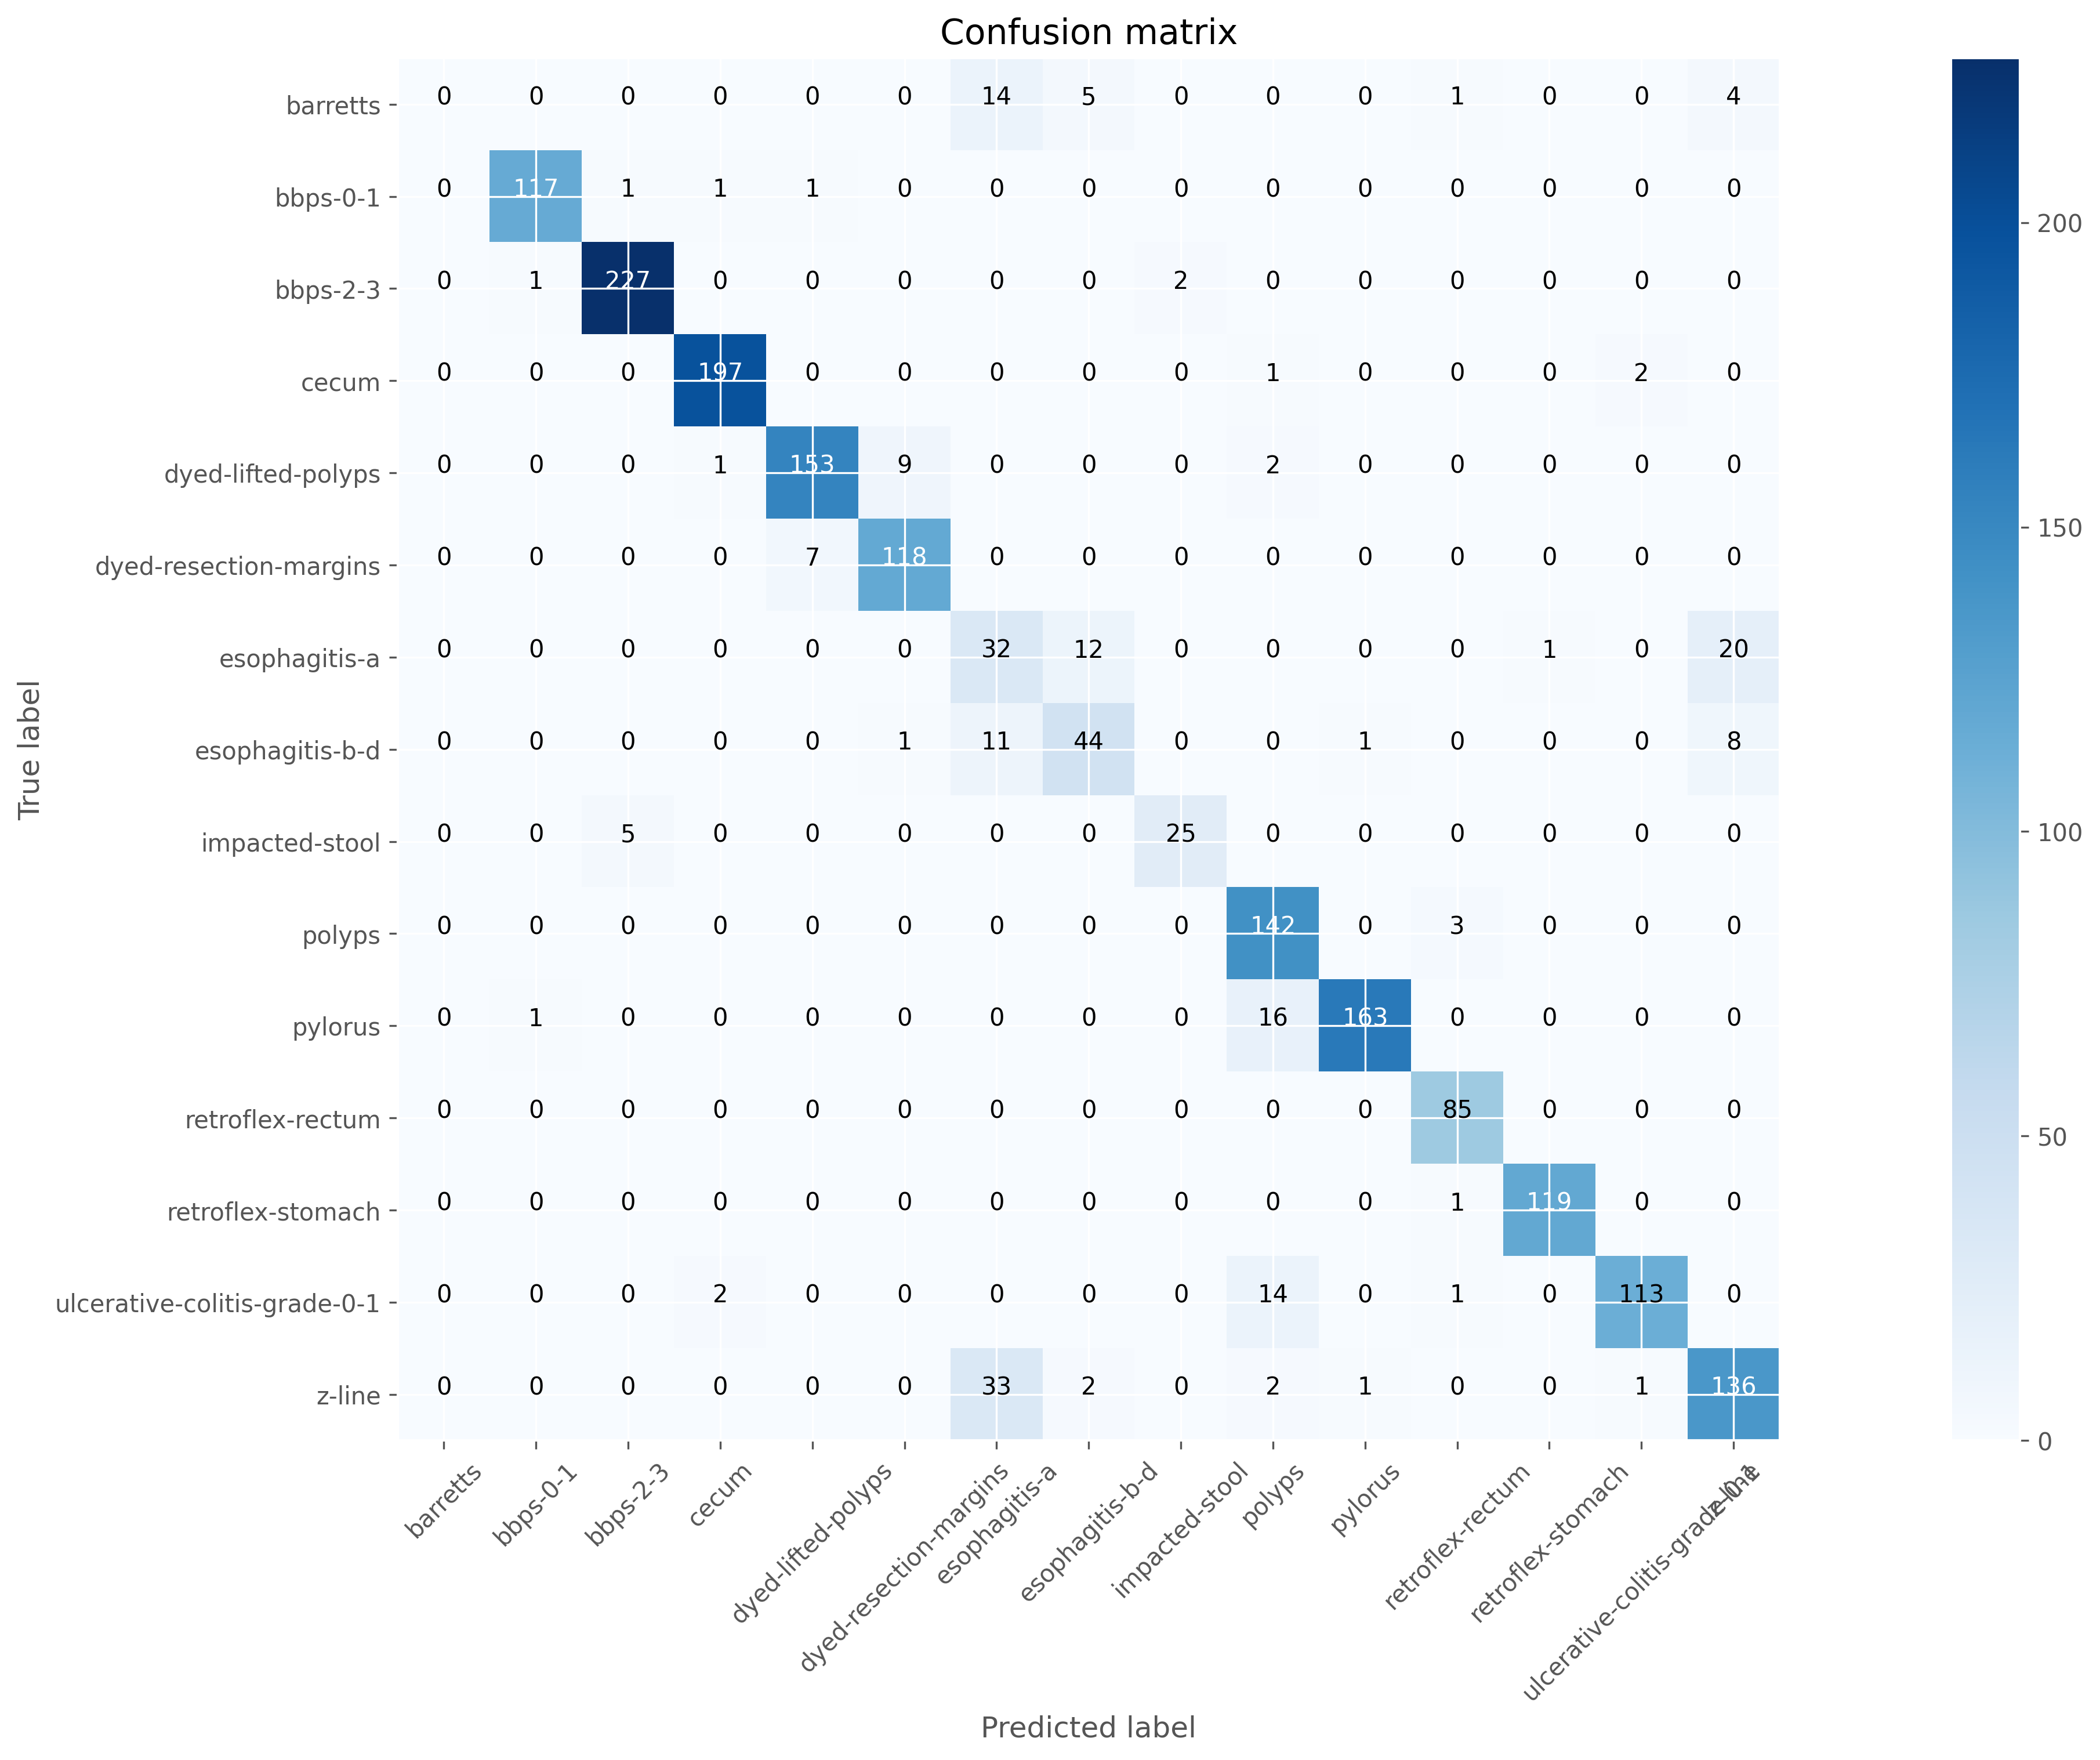

In [ ]:
#%% print classification report and plot confusion matrix

target_names = ['barretts', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'z-line'] 
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),vgg16_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()